# **Basic Neural Network in Tensorflow for steady 1D Nozzle Problem**
## This file is a brief documentation of the Python code.

The following cells will demonstrate how the tensorflow code works via a dry run through small snippets of code in sequence.

### The first snippet stands for *importing all necessary libraries..*

In [48]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

Note that there are 2 important data handling and numerical calculation libraries: numpy and scipy alongside tensorflow. Matplotlib is necessary to plot and visualize data.

Then we plant tensorflow random seed for initialization.

In [49]:
np.random.seed(1234)
tf.set_random_seed(1234)

### Now we *Define the callback* where we are going to use print the loss after each step:

In [50]:
def callback(loss):
    print('Loss: %.3e' % (loss))

### Actual Code inside the 'main' function:

In [51]:
if __name__ == "__main__": 
      
    N_train = 1260
    
    layers = [2, 10, 10, 1]

main function, inside which are the training and testing commands.

N_train variable stands for the number of training set data points.

Change the layer vector and the entire network structure changes. This is the list **representing out Neural net architecture** with first and last being the number of input and output parameters respectively.

### Load the data file and slice the training data:

In [52]:
    # Load Data
    data = np.loadtxt('cdnozzle1.txt')
    
    A = np.random.choice(range(data.shape[0]), size=(N_train,), replace=False)

    P_back_train = data[A,0:1].flatten()[:,None]
    x_train = data[A,1:2].flatten()[:,None]
    P_train = data[A,2:3].flatten()[:,None]

    # Training
    #model = PhysicsInformedNN(P_back_train, x_train, P_train, layers)
    X1 = np.concatenate([P_back_train, x_train], 1)
    lb = X1.min(0)
    ub = X1.max(0)

The C generated data was stored in file name **'cdnozzle.txt'**, which is read by ___numpy___ and stored as a new variable by name data. The training set length *N_train* is taken to be 1260 data points. The rest will be used as test set to validate the result of the training.

A is a random numbers vector, which will be used to randomly pick the 1260 rows of training data from the dataset.

The rest is mere slicing of dataset to get all required parameters.

**lb** and **ub** are the lower and upper bound respectively of X which would be later used to normalize the value of X before passing it onto the neural network. This is done to avoid explosion of network output values due to large training data values of X.

### Define a session and tensorial variables by placeholders:

In [53]:
# tf placeholders and graph
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

    P_back_tf = tf.placeholder(tf.float32, shape=[None, P_back_train.shape[1]])
    x_tf = tf.placeholder(tf.float32, shape=[None, x_train.shape[1]])
        
    P_tf = tf.placeholder(tf.float32, shape=[None, P_train.shape[1]])
        
    #P_pred = self.net_NS(self.P_back_tf, self.x_tf)
    #P_pred = self.neural_net(tf.concat([P_back, x], 1), self.weights, self.biases)

Define a session to run.

Respective tensors are defined as *variableName_tf* by using **tf.placeholder** function, shape similar to their numpy counterparts *variable_Name*.

In [54]:
X = tf.concat([P_back_tf, x_tf], 1)

Net concatenated input to the first layer is X.

### Random initialization of the Network

In [55]:
    weights = []
    biases = []
    num_layers = len(layers) 

    for l in range(0,num_layers-1):
        size=[layers[l], layers[l+1]]
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        W = tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
        

    num_layers = len(weights) + 1
        
    H = 2.0*(X - lb)/(ub - lb) - 1.0
    tf.cast(H, tf.float32)
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    P_pred = tf.add(tf.matmul(H, W), b)

This is basic network architecture and variables initialization snippet to create the weigths and biases tensor variables and assign random values to start with. The code snippet iterates over the **layers** vector to generate the tensors as stated.

### Define loss (or equivalently cost) function

In [56]:
loss = tf.reduce_sum(tf.square(P_tf - P_pred))

Note that the loss is simply taken as the MSE of the predicted output from the Neural network and ground truth from CFD.

### Define Optimizers

In [57]:
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 150000,
                                                                           'maxfun': 150000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
    optimizer_Adam = tf.train.AdamOptimizer()
    train_op_Adam = optimizer_Adam.minimize(loss)

This snippet actually trains the network weights based on the target of minimizing the loss. **tf_dict** is defined as the set of input and ideal output parameters for the given data in loop. For the given iterations 'nIter' (variable), the __train_op_Adam__ session is run.

Even after the iterations are finished, the optimizer continues to minimize the loss as compelled to by the statement **self.optimizer.minimize**, passing tf_dict to the loss expression defined as an attribute earlier in the class.

There are 2 optimizers used: external by Scipy (L-BFGS-B) and internal by Tensorflow (which is Adam). The external optimizer gives an extra push after the internal has done its job. No need to change the default options of the optimizers. We have used **Adam** optimizer in this case, since, it is the most common and generally the **fastest** known converger.

### Run the session

In [58]:
    init = tf.global_variables_initializer()
    sess.run(init)

Initialize all the variables in global scope and run the defines session.

### Command the network to train & print subsequent loss value

In [59]:
    tf_dict = {P_back_tf: P_back_train, 
                    x_tf: x_train, P_tf: P_train}
        
    start_time = time.time()
    for it in range(10000):
        sess.run(train_op_Adam, tf_dict)
            
        # Print
        if it % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = sess.run(loss, tf_dict)
                
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            start_time = time.time()

It: 0, Loss: 5.912e+02, Time: 0.03
It: 10, Loss: 4.676e+02, Time: 0.01
It: 20, Loss: 3.604e+02, Time: 0.01
It: 30, Loss: 2.621e+02, Time: 0.01
It: 40, Loss: 1.782e+02, Time: 0.01
It: 50, Loss: 1.148e+02, Time: 0.01
It: 60, Loss: 7.587e+01, Time: 0.01
It: 70, Loss: 5.940e+01, Time: 0.01
It: 80, Loss: 5.610e+01, Time: 0.01
It: 90, Loss: 5.612e+01, Time: 0.01
It: 100, Loss: 5.567e+01, Time: 0.01
It: 110, Loss: 5.508e+01, Time: 0.01
It: 120, Loss: 5.468e+01, Time: 0.01
It: 130, Loss: 5.437e+01, Time: 0.01
It: 140, Loss: 5.407e+01, Time: 0.01
It: 150, Loss: 5.377e+01, Time: 0.01
It: 160, Loss: 5.349e+01, Time: 0.01
It: 170, Loss: 5.321e+01, Time: 0.01
It: 180, Loss: 5.294e+01, Time: 0.01
It: 190, Loss: 5.267e+01, Time: 0.01
It: 200, Loss: 5.241e+01, Time: 0.01
It: 210, Loss: 5.214e+01, Time: 0.01
It: 220, Loss: 5.188e+01, Time: 0.01
It: 230, Loss: 5.162e+01, Time: 0.01
It: 240, Loss: 5.135e+01, Time: 0.01
It: 250, Loss: 5.108e+01, Time: 0.01
It: 260, Loss: 5.080e+01, Time: 0.01
It: 270, Los

It: 2280, Loss: 6.070e+00, Time: 0.01
It: 2290, Loss: 6.035e+00, Time: 0.01
It: 2300, Loss: 5.998e+00, Time: 0.01
It: 2310, Loss: 5.961e+00, Time: 0.01
It: 2320, Loss: 5.923e+00, Time: 0.01
It: 2330, Loss: 5.884e+00, Time: 0.01
It: 2340, Loss: 5.843e+00, Time: 0.01
It: 2350, Loss: 5.802e+00, Time: 0.01
It: 2360, Loss: 5.759e+00, Time: 0.01
It: 2370, Loss: 5.716e+00, Time: 0.01
It: 2380, Loss: 5.671e+00, Time: 0.01
It: 2390, Loss: 5.626e+00, Time: 0.01
It: 2400, Loss: 5.579e+00, Time: 0.01
It: 2410, Loss: 5.531e+00, Time: 0.01
It: 2420, Loss: 5.482e+00, Time: 0.01
It: 2430, Loss: 5.433e+00, Time: 0.01
It: 2440, Loss: 5.382e+00, Time: 0.01
It: 2450, Loss: 5.330e+00, Time: 0.01
It: 2460, Loss: 5.278e+00, Time: 0.01
It: 2470, Loss: 5.224e+00, Time: 0.01
It: 2480, Loss: 5.170e+00, Time: 0.01
It: 2490, Loss: 5.115e+00, Time: 0.01
It: 2500, Loss: 5.059e+00, Time: 0.01
It: 2510, Loss: 5.003e+00, Time: 0.01
It: 2520, Loss: 4.946e+00, Time: 0.01
It: 2530, Loss: 4.889e+00, Time: 0.01
It: 2540, Lo

It: 4510, Loss: 1.968e+00, Time: 0.01
It: 4520, Loss: 1.963e+00, Time: 0.01
It: 4530, Loss: 1.958e+00, Time: 0.01
It: 4540, Loss: 1.953e+00, Time: 0.01
It: 4550, Loss: 1.950e+00, Time: 0.01
It: 4560, Loss: 1.944e+00, Time: 0.01
It: 4570, Loss: 1.938e+00, Time: 0.01
It: 4580, Loss: 1.933e+00, Time: 0.01
It: 4590, Loss: 1.928e+00, Time: 0.01
It: 4600, Loss: 1.923e+00, Time: 0.01
It: 4610, Loss: 1.919e+00, Time: 0.01
It: 4620, Loss: 1.914e+00, Time: 0.01
It: 4630, Loss: 1.910e+00, Time: 0.01
It: 4640, Loss: 1.905e+00, Time: 0.01
It: 4650, Loss: 1.901e+00, Time: 0.01
It: 4660, Loss: 1.896e+00, Time: 0.01
It: 4670, Loss: 1.892e+00, Time: 0.01
It: 4680, Loss: 1.887e+00, Time: 0.01
It: 4690, Loss: 1.883e+00, Time: 0.01
It: 4700, Loss: 1.878e+00, Time: 0.01
It: 4710, Loss: 1.874e+00, Time: 0.01
It: 4720, Loss: 1.870e+00, Time: 0.01
It: 4730, Loss: 1.865e+00, Time: 0.01
It: 4740, Loss: 1.861e+00, Time: 0.01
It: 4750, Loss: 1.857e+00, Time: 0.01
It: 4760, Loss: 1.853e+00, Time: 0.01
It: 4770, Lo

It: 6810, Loss: 1.399e+00, Time: 0.01
It: 6820, Loss: 1.398e+00, Time: 0.01
It: 6830, Loss: 1.396e+00, Time: 0.01
It: 6840, Loss: 1.395e+00, Time: 0.01
It: 6850, Loss: 1.394e+00, Time: 0.01
It: 6860, Loss: 1.392e+00, Time: 0.01
It: 6870, Loss: 1.391e+00, Time: 0.01
It: 6880, Loss: 1.402e+00, Time: 0.01
It: 6890, Loss: 1.388e+00, Time: 0.01
It: 6900, Loss: 1.387e+00, Time: 0.01
It: 6910, Loss: 1.386e+00, Time: 0.01
It: 6920, Loss: 1.385e+00, Time: 0.01
It: 6930, Loss: 1.383e+00, Time: 0.01
It: 6940, Loss: 1.382e+00, Time: 0.01
It: 6950, Loss: 1.381e+00, Time: 0.01
It: 6960, Loss: 1.380e+00, Time: 0.01
It: 6970, Loss: 1.378e+00, Time: 0.01
It: 6980, Loss: 1.377e+00, Time: 0.01
It: 6990, Loss: 1.376e+00, Time: 0.01
It: 7000, Loss: 1.375e+00, Time: 0.01
It: 7010, Loss: 1.373e+00, Time: 0.01
It: 7020, Loss: 1.372e+00, Time: 0.01
It: 7030, Loss: 1.371e+00, Time: 0.01
It: 7040, Loss: 1.370e+00, Time: 0.01
It: 7050, Loss: 1.368e+00, Time: 0.01
It: 7060, Loss: 1.367e+00, Time: 0.01
It: 7070, Lo

It: 9110, Loss: 1.176e+00, Time: 0.01
It: 9120, Loss: 1.175e+00, Time: 0.01
It: 9130, Loss: 1.174e+00, Time: 0.01
It: 9140, Loss: 1.173e+00, Time: 0.01
It: 9150, Loss: 1.172e+00, Time: 0.01
It: 9160, Loss: 1.171e+00, Time: 0.01
It: 9170, Loss: 1.170e+00, Time: 0.01
It: 9180, Loss: 1.170e+00, Time: 0.01
It: 9190, Loss: 1.172e+00, Time: 0.01
It: 9200, Loss: 1.168e+00, Time: 0.01
It: 9210, Loss: 1.167e+00, Time: 0.01
It: 9220, Loss: 1.166e+00, Time: 0.01
It: 9230, Loss: 1.165e+00, Time: 0.01
It: 9240, Loss: 1.164e+00, Time: 0.01
It: 9250, Loss: 1.163e+00, Time: 0.01
It: 9260, Loss: 1.162e+00, Time: 0.01
It: 9270, Loss: 1.161e+00, Time: 0.01
It: 9280, Loss: 1.160e+00, Time: 0.01
It: 9290, Loss: 1.159e+00, Time: 0.01
It: 9300, Loss: 1.158e+00, Time: 0.01
It: 9310, Loss: 1.157e+00, Time: 0.01
It: 9320, Loss: 1.164e+00, Time: 0.01
It: 9330, Loss: 1.156e+00, Time: 0.01
It: 9340, Loss: 1.155e+00, Time: 0.01
It: 9350, Loss: 1.153e+00, Time: 0.01
It: 9360, Loss: 1.152e+00, Time: 0.01
It: 9370, Lo

The training set is passed on as a dictionary object to the network, so as to first get converted to a tensorial variable and then fed into training.

range(10000) indicated the number of iterations Adam is going to run. it%10 indicates that only every 10th iteration result will be printed on to the user screen.

In [60]:
    optimizer.minimize(sess,
                            feed_dict = tf_dict,
                            fetches = [loss],
                            loss_callback = callback)

Loss: 1.086e+00
Loss: 1.042e+04
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.086e+00
Loss: 1.085e+00
Loss: 1.085e+00
Loss: 1.084e+00
Loss: 1.084e+00
Loss: 1.084e+00
Loss: 1.084e+00
Loss: 1.083e+00
Loss: 1.083e+00
Loss: 1.082e+00
Loss: 1.082e+00
Loss: 1.081e+00
Loss: 1.078e+00
Loss: 1.075e+00
Loss: 1.076e+00
Loss: 1.073e+00
Loss: 1.070e+00
Loss: 1.068e+00
Loss: 1.068e+00
Loss: 1.067e+00
Loss: 1.065e+00
Loss: 1.063e+00
Loss: 1.062e+00
Loss: 1.061e+00
Loss: 1.060e+00
Loss: 1.059e+00
Loss: 1.057e+00
Loss: 1.054e+00
Loss: 1.051e+00
Loss: 1.048e+00
Loss: 1.046e+00
Loss: 1.045e+00
Loss: 1.044e+00
Loss: 1.043e+00
Loss: 1.042e+00
Loss: 1.040e+00
Loss: 1.034e+00
Loss: 1.030e+00
Loss: 1.029e+00
Loss: 1.029e+00
Loss: 1.028e+00
Loss: 1.026e+00
Loss: 1.023e+00
Loss: 1.019e+00
Loss: 1.011e+00
Loss: 1.007e+00
Loss: 1.006e+00
Loss: 1.005e+00
Loss: 1.003e+00
Loss: 9.985e-01
Loss: 9.898e-01
Loss: 9.808e-01
Loss: 1.006e+00
Loss: 9.

Loss: 6.406e-01
Loss: 6.405e-01
Loss: 6.405e-01
Loss: 6.403e-01
Loss: 6.401e-01
Loss: 6.399e-01
Loss: 6.398e-01
Loss: 6.396e-01
Loss: 6.394e-01
Loss: 6.392e-01
Loss: 6.394e-01
Loss: 6.391e-01
Loss: 6.390e-01
Loss: 6.389e-01
Loss: 6.387e-01
Loss: 6.395e-01
Loss: 6.386e-01
Loss: 6.385e-01
Loss: 6.383e-01
Loss: 6.382e-01
Loss: 6.380e-01
Loss: 6.378e-01
Loss: 6.377e-01
Loss: 6.376e-01
Loss: 6.374e-01
Loss: 6.373e-01
Loss: 6.369e-01
Loss: 6.367e-01
Loss: 6.364e-01
Loss: 6.360e-01
Loss: 6.356e-01
Loss: 6.355e-01
Loss: 6.352e-01
Loss: 6.351e-01
Loss: 6.350e-01
Loss: 6.349e-01
Loss: 6.348e-01
Loss: 6.347e-01
Loss: 6.346e-01
Loss: 6.345e-01
Loss: 6.342e-01
Loss: 6.340e-01
Loss: 6.339e-01
Loss: 6.337e-01
Loss: 6.336e-01
Loss: 6.336e-01
Loss: 6.335e-01
Loss: 6.333e-01
Loss: 6.331e-01
Loss: 6.327e-01
Loss: 6.325e-01
Loss: 6.323e-01
Loss: 6.321e-01
Loss: 6.320e-01
Loss: 6.320e-01
Loss: 6.319e-01
Loss: 6.319e-01
Loss: 6.318e-01
Loss: 6.317e-01
Loss: 6.317e-01
Loss: 6.316e-01
Loss: 6.316e-01
Loss: 6.

Loss: 5.769e-01
Loss: 5.768e-01
Loss: 5.767e-01
Loss: 5.765e-01
Loss: 5.764e-01
Loss: 5.763e-01
Loss: 5.761e-01
Loss: 5.761e-01
Loss: 5.759e-01
Loss: 5.758e-01
Loss: 5.757e-01
Loss: 5.755e-01
Loss: 5.753e-01
Loss: 5.752e-01
Loss: 5.750e-01
Loss: 5.748e-01
Loss: 5.747e-01
Loss: 5.745e-01
Loss: 5.742e-01
Loss: 5.739e-01
Loss: 5.744e-01
Loss: 5.738e-01
Loss: 5.735e-01
Loss: 5.733e-01
Loss: 5.731e-01
Loss: 5.729e-01
Loss: 5.727e-01
Loss: 5.727e-01
Loss: 5.726e-01
Loss: 5.726e-01
Loss: 5.726e-01
Loss: 5.725e-01
Loss: 5.726e-01
Loss: 5.725e-01
Loss: 5.724e-01
Loss: 5.722e-01
Loss: 5.721e-01
Loss: 5.720e-01
Loss: 5.720e-01
Loss: 5.720e-01
Loss: 5.719e-01
Loss: 5.719e-01
Loss: 5.719e-01
Loss: 5.718e-01
Loss: 5.718e-01
Loss: 5.718e-01
Loss: 5.717e-01
Loss: 5.716e-01
Loss: 5.716e-01
Loss: 5.715e-01
Loss: 5.713e-01
Loss: 5.712e-01
Loss: 5.710e-01
Loss: 5.709e-01
Loss: 5.709e-01
Loss: 5.709e-01
Loss: 5.708e-01
Loss: 5.707e-01
Loss: 5.705e-01
Loss: 5.704e-01
Loss: 5.700e-01
Loss: 5.699e-01
Loss: 5.

Loss: 5.167e-01
Loss: 5.165e-01
Loss: 5.162e-01
Loss: 5.159e-01
Loss: 5.155e-01
Loss: 5.152e-01
Loss: 5.150e-01
Loss: 5.148e-01
Loss: 5.146e-01
Loss: 5.144e-01
Loss: 5.143e-01
Loss: 5.141e-01
Loss: 5.140e-01
Loss: 5.139e-01
Loss: 5.139e-01
Loss: 5.138e-01
Loss: 5.136e-01
Loss: 5.134e-01
Loss: 5.133e-01
Loss: 5.128e-01
Loss: 5.125e-01
Loss: 5.123e-01
Loss: 5.120e-01
Loss: 5.117e-01
Loss: 5.115e-01
Loss: 5.112e-01
Loss: 5.110e-01
Loss: 5.109e-01
Loss: 5.108e-01
Loss: 5.107e-01
Loss: 5.106e-01
Loss: 5.104e-01
Loss: 5.101e-01
Loss: 5.099e-01
Loss: 5.098e-01
Loss: 5.094e-01
Loss: 5.093e-01
Loss: 5.092e-01
Loss: 5.091e-01
Loss: 5.090e-01
Loss: 5.089e-01
Loss: 5.088e-01
Loss: 5.087e-01
Loss: 5.085e-01
Loss: 5.083e-01
Loss: 5.081e-01
Loss: 5.081e-01
Loss: 5.080e-01
Loss: 5.077e-01
Loss: 5.075e-01
Loss: 5.074e-01
Loss: 5.073e-01
Loss: 5.071e-01
Loss: 5.068e-01
Loss: 5.066e-01
Loss: 5.062e-01
Loss: 5.060e-01
Loss: 5.057e-01
Loss: 5.054e-01
Loss: 5.051e-01
Loss: 5.048e-01
Loss: 5.044e-01
Loss: 5.

Loss: 3.826e-01
Loss: 3.822e-01
Loss: 3.819e-01
Loss: 3.816e-01
Loss: 3.815e-01
Loss: 3.814e-01
Loss: 3.812e-01
Loss: 3.811e-01
Loss: 3.809e-01
Loss: 3.807e-01
Loss: 3.806e-01
Loss: 3.805e-01
Loss: 3.802e-01
Loss: 3.800e-01
Loss: 3.797e-01
Loss: 3.796e-01
Loss: 3.794e-01
Loss: 3.791e-01
Loss: 3.788e-01
Loss: 3.783e-01
Loss: 3.778e-01
Loss: 3.773e-01
Loss: 3.769e-01
Loss: 3.769e-01
Loss: 3.766e-01
Loss: 3.764e-01
Loss: 3.763e-01
Loss: 3.762e-01
Loss: 3.761e-01
Loss: 3.759e-01
Loss: 3.757e-01
Loss: 3.756e-01
Loss: 3.754e-01
Loss: 3.749e-01
Loss: 3.747e-01
Loss: 3.745e-01
Loss: 3.744e-01
Loss: 3.742e-01
Loss: 3.740e-01
Loss: 3.737e-01
Loss: 3.735e-01
Loss: 3.736e-01
Loss: 3.734e-01
Loss: 3.733e-01
Loss: 3.732e-01
Loss: 3.730e-01
Loss: 3.728e-01
Loss: 3.725e-01
Loss: 3.723e-01
Loss: 3.720e-01
Loss: 3.718e-01
Loss: 3.715e-01
Loss: 3.714e-01
Loss: 3.713e-01
Loss: 3.712e-01
Loss: 3.711e-01
Loss: 3.707e-01
Loss: 3.704e-01
Loss: 3.702e-01
Loss: 3.700e-01
Loss: 3.700e-01
Loss: 3.699e-01
Loss: 3.

Loss: 2.586e-01
Loss: 2.584e-01
Loss: 2.582e-01
Loss: 2.580e-01
Loss: 2.582e-01
Loss: 2.578e-01
Loss: 2.575e-01
Loss: 2.573e-01
Loss: 2.567e-01
Loss: 2.563e-01
Loss: 2.559e-01
Loss: 2.556e-01
Loss: 2.554e-01
Loss: 2.554e-01
Loss: 2.553e-01
Loss: 2.552e-01
Loss: 2.551e-01
Loss: 2.549e-01
Loss: 2.548e-01
Loss: 2.546e-01
Loss: 2.544e-01
Loss: 2.543e-01
Loss: 2.542e-01
Loss: 2.541e-01
Loss: 2.540e-01
Loss: 2.539e-01
Loss: 2.538e-01
Loss: 2.537e-01
Loss: 2.536e-01
Loss: 2.535e-01
Loss: 2.534e-01
Loss: 2.534e-01
Loss: 2.533e-01
Loss: 2.532e-01
Loss: 2.532e-01
Loss: 2.533e-01
Loss: 2.531e-01
Loss: 2.531e-01
Loss: 2.530e-01
Loss: 2.529e-01
Loss: 2.528e-01
Loss: 2.527e-01
Loss: 2.526e-01
Loss: 2.525e-01
Loss: 2.524e-01
Loss: 2.523e-01
Loss: 2.521e-01
Loss: 2.519e-01
Loss: 2.516e-01
Loss: 2.521e-01
Loss: 2.516e-01
Loss: 2.514e-01
Loss: 2.512e-01
Loss: 2.511e-01
Loss: 2.510e-01
Loss: 2.508e-01
Loss: 2.508e-01
Loss: 2.507e-01
Loss: 2.507e-01
Loss: 2.506e-01
Loss: 2.505e-01
Loss: 2.504e-01
Loss: 2.

Loss: 1.850e-01
Loss: 1.850e-01
Loss: 1.849e-01
Loss: 1.849e-01
Loss: 1.849e-01
Loss: 1.848e-01
Loss: 1.848e-01
Loss: 1.848e-01
Loss: 1.847e-01
Loss: 1.847e-01
Loss: 1.847e-01
Loss: 1.846e-01
Loss: 1.846e-01
Loss: 1.845e-01
Loss: 1.846e-01
Loss: 1.845e-01
Loss: 1.845e-01
Loss: 1.844e-01
Loss: 1.843e-01
Loss: 1.843e-01
Loss: 1.842e-01
Loss: 1.841e-01
Loss: 1.840e-01
Loss: 1.840e-01
Loss: 1.839e-01
Loss: 1.839e-01
Loss: 1.838e-01
Loss: 1.838e-01
Loss: 1.837e-01
Loss: 1.835e-01
Loss: 1.834e-01
Loss: 1.835e-01
Loss: 1.833e-01
Loss: 1.832e-01
Loss: 1.830e-01
Loss: 1.830e-01
Loss: 1.830e-01
Loss: 1.829e-01
Loss: 1.829e-01
Loss: 1.828e-01
Loss: 1.828e-01
Loss: 1.827e-01
Loss: 1.826e-01
Loss: 1.826e-01
Loss: 1.825e-01
Loss: 1.824e-01
Loss: 1.823e-01
Loss: 1.823e-01
Loss: 1.823e-01
Loss: 1.822e-01
Loss: 1.821e-01
Loss: 1.820e-01
Loss: 1.819e-01
Loss: 1.819e-01
Loss: 1.818e-01
Loss: 1.817e-01
Loss: 1.816e-01
Loss: 1.815e-01
Loss: 1.814e-01
Loss: 1.813e-01
Loss: 1.812e-01
Loss: 1.811e-01
Loss: 1.

Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.548e-01
Loss: 1.547e-01
Loss: 1.547e-01
Loss: 1.547e-01
Loss: 1.547e-01
Loss: 1.547e-01
Loss: 1.546e-01
Loss: 1.546e-01
Loss: 1.546e-01
Loss: 1.546e-01
Loss: 1.546e-01
Loss: 1.545e-01
Loss: 1.545e-01
Loss: 1.545e-01
Loss: 1.544e-01
Loss: 1.544e-01
Loss: 1.545e-01
Loss: 1.544e-01
Loss: 1.544e-01
Loss: 1.543e-01
Loss: 1.543e-01
Loss: 1.543e-01
Loss: 1.543e-01
Loss: 1.543e-01
Loss: 1.543e-01
Loss: 1.542e-01
Loss: 1.542e-01
Loss: 1.542e-01
Loss: 1.541e-01
Loss: 1.541e-01
Loss: 1.541e-01
Loss: 1.541e-01
Loss: 1.540e-01
Loss: 1.540e-01
Loss: 1.540e-01
Loss: 1.540e-01
Loss: 1.539e-01
Loss: 1.539e-01
Loss: 1.539e-01
Loss: 1.539e-01
Loss: 1.538e-01
Loss: 1.538e-01
Loss: 1.538e-01
Loss: 1.537e-01
Loss: 1.537e-01
Loss: 1.536e-01
Loss: 1.536e-01
Loss: 1.536e-01
Loss: 1.535e-01
Loss: 1.535e-01
Loss: 1.535e-01
Loss: 1.534e-01
Loss: 1.534e-01
Loss: 1.534e-01
Loss: 1.

Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.430e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.430e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.429e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.428e-01
Loss: 1.427e-01
Loss: 1.427e-01
Loss: 1.427e-01
Loss: 1.427e-01
Loss: 1.427e-01
Loss: 1.427e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.426e-01
Loss: 1.425e-01
Loss: 1.425e-01
Loss: 1.425e-01
Loss: 1.425e-01
Loss: 1.425e-01
Loss: 1.

Loss: 1.381e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.382e-01
Loss: 1.380e-01
Loss: 1.380e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.379e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.379e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.378e-01
Loss: 1.377e-01
Loss: 1.377e-01
Loss: 1.377e-01
Loss: 1.378e-01
Loss: 1.377e-01
Loss: 1.377e-01
Loss: 1.378e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.376e-01
Loss: 1.375e-01
Loss: 1.375e-01
Loss: 1.375e-01
Loss: 1.375e-01
Loss: 1.375e-01
Loss: 1.375e-01
Loss: 1.374e-01
Loss: 1.

Loss: 1.292e-01
Loss: 1.292e-01
Loss: 1.291e-01
Loss: 1.291e-01
Loss: 1.290e-01
Loss: 1.290e-01
Loss: 1.289e-01
Loss: 1.289e-01
Loss: 1.289e-01
Loss: 1.289e-01
Loss: 1.289e-01
Loss: 1.288e-01
Loss: 1.288e-01
Loss: 1.288e-01
Loss: 1.288e-01
Loss: 1.288e-01
Loss: 1.289e-01
Loss: 1.288e-01
Loss: 1.288e-01
Loss: 1.287e-01
Loss: 1.287e-01
Loss: 1.287e-01
Loss: 1.287e-01
Loss: 1.286e-01
Loss: 1.286e-01
Loss: 1.286e-01
Loss: 1.286e-01
Loss: 1.285e-01
Loss: 1.285e-01
Loss: 1.285e-01
Loss: 1.285e-01
Loss: 1.284e-01
Loss: 1.284e-01
Loss: 1.284e-01
Loss: 1.283e-01
Loss: 1.283e-01
Loss: 1.282e-01
Loss: 1.282e-01
Loss: 1.281e-01
Loss: 1.281e-01
Loss: 1.281e-01
Loss: 1.280e-01
Loss: 1.280e-01
Loss: 1.280e-01
Loss: 1.279e-01
Loss: 1.279e-01
Loss: 1.279e-01
Loss: 1.279e-01
Loss: 1.278e-01
Loss: 1.278e-01
Loss: 1.278e-01
Loss: 1.278e-01
Loss: 1.277e-01
Loss: 1.277e-01
Loss: 1.277e-01
Loss: 1.276e-01
Loss: 1.276e-01
Loss: 1.276e-01
Loss: 1.275e-01
Loss: 1.275e-01
Loss: 1.275e-01
Loss: 1.274e-01
Loss: 1.

Loss: 1.140e-01
Loss: 1.140e-01
Loss: 1.140e-01
Loss: 1.140e-01
Loss: 1.139e-01
Loss: 1.139e-01
Loss: 1.139e-01
Loss: 1.139e-01
Loss: 1.139e-01
Loss: 1.139e-01
Loss: 1.138e-01
Loss: 1.138e-01
Loss: 1.138e-01
Loss: 1.137e-01
Loss: 1.137e-01
Loss: 1.137e-01
Loss: 1.137e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.136e-01
Loss: 1.135e-01
Loss: 1.135e-01
Loss: 1.135e-01
Loss: 1.135e-01
Loss: 1.134e-01
Loss: 1.135e-01
Loss: 1.134e-01
Loss: 1.134e-01
Loss: 1.134e-01
Loss: 1.133e-01
Loss: 1.133e-01
Loss: 1.133e-01
Loss: 1.133e-01
Loss: 1.133e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.132e-01
Loss: 1.131e-01
Loss: 1.131e-01
Loss: 1.131e-01
Loss: 1.131e-01
Loss: 1.131e-01
Loss: 1.131e-01
Loss: 1.130e-01
Loss: 1.131e-01
Loss: 1.130e-01
Loss: 1.130e-01
Loss: 1.130e-01
Loss: 1.129e-01
Loss: 1.129e-01
Loss: 1.129e-01
Loss: 1.128e-01
Loss: 1.128e-01
Loss: 1.127e-01
Loss: 1.

**optimize.minimize** fetches loss and iteratively performs backpropop.

After Adam, the external optimizer takes over.

### Generate Test dataset

In [61]:
    # Test Data
    #data1 = data
    #data1 = np.delete(data1, A, 0)
    data_test = np.loadtxt('cdnozzle_test.txt')

    #P_back_test = data1[:,0:1].flatten()[:,None]
    #x_test = data1[:,1:2].flatten()[:,None]
    for i in range(0, 8):
        P_back_test = 0.01*(27+8*i)*np.ones((100,1), dtype = float)
        x_test = 0.03*np.arange(1, 101, dtype=float).flatten()[:,None]
        P_test = data_test[100*i:100*(i+1),2:3]

Yes, the test data is actually extracted from a different file in order to ensure minimal incidence of intrapolation or extrapolation of the test results by the network.

### Perform Prediction

In [62]:
    # Prediction
        #P_pred = model.predict(P_back_test, x_test)
        tf_dict_test = {P_back_tf: P_back_test, x_tf: x_test}
        
        P_pred_test = sess.run(P_pred, tf_dict_test)

Very similar to the training, the test dataset is also fed into the network as a dictionary object.

P_pred_test is the predicted ouput by the network.

### Visualize the results

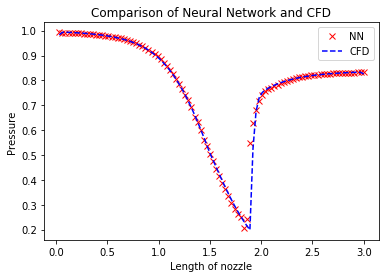

In [63]:
        plt.plot(x_test, P_pred_test, 'rx', label='NN')
        plt.plot(x_test, P_test, 'b--', label='CFD')
        plt.legend()
        plt.title('Comparison of Neural Network and CFD')
        plt.xlabel('Length of nozzle')
        plt.ylabel('Pressure')
        plt.show()

Plot the test results against the ground truth.

In [64]:
    #Error
        error_P = np.linalg.norm(P_test-P_pred_test,2)/np.linalg.norm(P_test,2)
        print('Error P: %e' % (error_P))

Error P: 4.586800e-02


The normalized error is printed on the screen.